In [2]:
#run this in conda cmd before jupyter: jupyter nbextension enable --py widgetsnbextension
import numpy as np
from pathlib import Path
import pathlib
from os import listdir
from os.path import isfile, join, exists
import json
from scipy import ndimage as ndi
import time

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops, regionprops_table
from skimage import io
from skimage.transform import resize

import pylab

# %matplotlib inline 
%matplotlib widget 
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import ImageAnalysis
import Morphology
import cv2 
from skimage.exposure import histogram
from skimage.filters import apply_hysteresis_threshold

import pandas as pd

In [3]:
input_data_path = "C:\\RESEARCH\\Mitophagy_data\\Time_split\\Output\\"
list_of_files = [(input_data_path + f, f) for f in listdir(input_data_path) if isfile(join(input_data_path, f)) and f.endswith('.tif')]

In [4]:
def read_sample(image_path):
    sample = io.imread(image_path)
    if sample.shape[-1] == 3:
        return np.mean(sample, axis=-1).astype('uint8')
    else:
        return sample

In [5]:
sample0 = 0
initial_sample = read_sample(list_of_files[sample0][0])
initial_name = list_of_files[sample0][1]
z0 = int((initial_sample.shape[0]/2)-1)
low_thresh = np.max(initial_sample)
high_thresh = np.max(initial_sample)
threshold_params = {}
mip_view = True
save_path = "C:\\RESEARCH\\Mitophagy_data\\gui params\\rensu_thresholds.json"
sample_ratings = {}
processing_time_string = ""

In [6]:
input_path = "C:\\RESEARCH\\Mitophagy_data\\gui params\\rensu_thresholds.json"
rating_path = "C:\\RESEARCH\\Mitophagy_data\\gui params\\rensu_ratings.json"
def retreive_params():
    global threshold_params
    if isfile(input_path):
        param_file = open(input_path)
        result = json.load(param_file)
        param_file.close()
        threshold_params = result
        
        
sample_ratings = {}
sample_details = {}
def sample_to_path(thresholded_list):
    global threshold_params
    global list_of_files
    results = {}
    sample_count = 0
    for lof in list_of_files:
        if lof[1] in threshold_params and lof[1] in thresholded_list:
            thresh_details = threshold_params[lof[1]]
            results[sample_count] = [lof[0], lof[1], thresh_details["low"], thresh_details["high"]]
            sample_count += 1
    return results

In [7]:
def mask_image(image, low, high):
    zero_plane = np.zeros_like(image)
    mask = apply_hysteresis_threshold(image, low, high).astype('int')
    masked = image*mask
    orig_rgb = np.stack((image, image, image), axis=-1)
    thresh_rgb = np.stack((mask*255, zero_plane, zero_plane), axis=-1)
    combined_stack = orig_rgb * 0.6 + thresh_rgb * 0.4
    return masked, combined_stack

In [8]:
def updateThresh(val):
    global masked_image
    global mask_overlay
    global z0
    global threshold_params
    global initial_name
    global initial_sample
    global processing_time_string
    low_thresh = low_slide.val
    high_thresh = high_slide.val
    if high_thresh < low_thresh:
        high_thresh = low_thresh
        high_slide.set_val(high_thresh)
    threshold_params[initial_name] = {"low":low_thresh, "high":high_thresh}
    z0 = z_slide.val
    thresh_time_start = time.process_time()
    masked_image, mask_overlay = mask_image(initial_sample, low_thresh, high_thresh)
    thresh_time_end = time.process_time()
    processing_time_string += "Threshold Update Time: " + str(thresh_time_end - thresh_time_start) + "\n"
    ax1.cla()
    ax2.cla()
    display_orig_time_start = time.process_time()
    ax1.imshow(display_image(initial_sample))
    display_orig_time_end = time.process_time()
    display_thresh_time_start = time.process_time()
    ax2.imshow(display_image(mask_overlay/255))
    display_thresh_time_end = time.process_time()
    ax1.axis('off')
    ax2.axis('off')
    processing_time_string += "Display times are: " + str(display_orig_time_end - display_orig_time_start) + " for original"
    processing_time_string += " and " + str(display_thresh_time_end - display_thresh_time_start) + " for threshold." + "\n"

def updateZ(val):
    global masked_image
    global mask_overlay
    global z0
    global initial_sample
    z0 = z_slide.val
    ax1.cla()
    ax2.cla()
    ax1.imshow(display_image(initial_sample))
    ax2.imshow(display_image(mask_overlay/255))
    ax1.axis('off')
    ax2.axis('off')

def updateSample(event):
    global sample0
    global initial_sample
    global initial_name
    global z0
    global low_thresh
    global high_thresh
    global threshold_params
    global processing_time_string
    sample_change_start = time.process_time()
    sample0 = sample_slide.val
    sample_read_start = time.process_time()
    initial_sample = read_sample(list_of_files[sample0][0])
    sample_read_end = time.process_time()
    initial_name = list_of_files[sample0][1]
    fig1.suptitle(initial_name)
    sample_min = np.min(initial_sample)
    sample_max = np.max(initial_sample)
    sample_slices = initial_sample.shape[0]
    low_slide.eventson = False
    high_slide.eventson = False
    low_slide.valmin = sample_min
    high_slide.valmin = sample_min
    low_slide.valmax = sample_max
    high_slide.valmax = sample_max
    z_slide.valmax = sample_slices-1
    if initial_name in threshold_params:
        low_slide.valinit = threshold_params[initial_name]['low']
        high_slide.valinit = threshold_params[initial_name]['high']
        low_thresh = threshold_params[initial_name]['low']
        high_thresh = threshold_params[initial_name]['high']
    else:
        low_slide.valinit = sample_min
        high_slide.valinit = sample_min + (sample_max-sample_min)/2
        low_thresh = sample_min
        high_thresh = sample_min + (sample_max-sample_min)/2
    z_slide.valinit = abs(int((sample_slices/2)-1))
    low_slide.reset()
    high_slide.reset()
    z_slide.reset()
    low_slide.eventson = True
    high_slide.eventson = True
    z0 = abs(int((sample_slices/2)-1))
    masked_image, mask_overlay = mask_image(initial_sample, low_thresh, high_thresh)
    ax1.imshow(display_image(initial_sample))
    ax2.imshow(display_image(mask_overlay/255))
    ax1.axis('off')
    ax2.axis('off')
    sample_change_end = time.process_time()
    processing_time_string += "Sample change time: " + str(sample_change_end - sample_change_start) + "\n"
    processing_time_string += "Sample read time: " + str(sample_read_end - sample_read_start) + "\n"

def nextSample1(event):
    global sample0
    global initial_sample
    global initial_name
    global z0
    global low_thresh
    global high_thresh
    global threshold_params
    next_sample_count = sample0 + 1
    if next_sample_count <= len(list_of_files):
        sample0 = next_sample_count
        low_slide.eventson = False
        high_slide.eventson = False
        sample_slide.set_val(next_sample_count)
        initial_sample = read_sample(list_of_files[sample0][0])
        initial_name = list_of_files[sample0][1]
        fig1.suptitle(initial_name)
        sample_min = np.min(initial_sample)
        sample_max = np.max(initial_sample)
        sample_slices = initial_sample.shape[0]
        low_slide.valmin = sample_min
        high_slide.valmin = sample_min
        low_slide.valmax = sample_max
        high_slide.valmax = sample_max
        z_slide.valmax = sample_slices-1
        if initial_name in threshold_params:
            low_slide.valinit = threshold_params[initial_name]['low']
            high_slide.valinit = threshold_params[initial_name]['high']
            low_thresh = threshold_params[initial_name]['low']
            high_thresh = threshold_params[initial_name]['high']
        else:
            low_slide.valinit = sample_min
            high_slide.valinit = sample_min + (sample_max-sample_min)/2
            low_thresh = sample_min
            high_thresh = sample_min + (sample_max-sample_min)/2
        z_slide.valinit = abs(int((sample_slices/2)-1))
        low_slide.reset()
        high_slide.reset()
        z_slide.reset()
        low_slide.eventson = True
        high_slide.eventson = True
        z0 = abs(int((sample_slices/2)-1))
        masked_image, mask_overlay = mask_image(initial_sample, low_thresh, high_thresh)
        ax1.imshow(display_image(initial_sample))
        ax2.imshow(display_image(mask_overlay/255))
        ax1.axis('off')
        ax2.axis('off')

def updateMIP(label):
    global mip_view
    global masked_image
    global mask_overlay
    global initial_sample
    if label == "MIP":
        mip_view = True
    else:
        mip_view = False
    ax1.imshow(display_image(initial_sample))
    ax2.imshow(display_image(mask_overlay/255))
    ax1.axis('off')
    ax2.axis('off')

def display_image(image):
    global mip_view
    global z0
    if mip_view:
        return np.amax(image, axis=0)
    else:
        return image[z0]

def save_params(event):
    global threshold_params
    global save_path
    with open(save_path, 'w') as j:
        json.dump(threshold_params, j)
    return

In [9]:
def updateZ2(val):
    global z1
    global thresholded_images
    global thresh_option_selected
    global thresh_type_selected
    z1 = z_slide2.val
    ax3.cla()
    ax4.cla()
    ax3.imshow(display_image2(apply_thresholding()))
    ax4.imshow(display_image2(thresholded_images[thresh_type_selected + thresh_option_selected]))
    ax3.axis('off')
    ax4.axis('off')

def updateSample2(event):
    global sample1
    global initial_sample2
    global initial_name2
    global z1
    global thresh_option_selected
    global thresholded_images
    global thresh_type_selected
    global auto_path
    global image_configs
    global thresholded_samples
    global low2
    global high2
    global sample_ratings
    sample1 = sample_slide2.val
    initial_sample2 = read_sample(sample_details[sample1][0])
    initial_name2 = sample_details[sample1][1]
    fig2.suptitle(initial_name2)
    sample_name2 = initial_name2.split('.')[0]
    low2 = sample_details[sample1][2]
    high2 = sample_details[sample1][3]
    thresholded_images, image_configs = combine_images(auto_path, sample_name2, thresholded_samples)
    sample_slices = initial_sample2.shape[0]
    z_slide2.valmax = sample_slices-1
    z_slide2.valinit = abs(int((sample_slices/2)-1))
    z_slide2.reset()
    z1 = abs(int((sample_slices/2)-1))
    rating_slide.eventson = False
    if initial_name2 in sample_ratings:
        config_setup = image_configs[(thresh_type_selected, thresh_option_selected)][1:]
        type_option = config_setup[0] + config_setup[1]
        if type_option in sample_ratings[initial_name2]:
            rating_val = sample_ratings[initial_name2][type_option]
            rating_slide.set_val(rating_val)
            rating_slide.valinit = rating_val
        else:
            rating_slide.valinit = 3
            rating_slide.set_val(3)
    else:
            rating_slide.valinit = 3
            rating_slide.set_val(3)
    rating_slide.reset()
    rating_slide.eventson = True
    ax3.cla()
    ax4.cla()
    ax3.imshow(display_image2(apply_thresholding()))
    ax4.imshow(display_image2(thresholded_images[thresh_type_selected + thresh_option_selected]))
    ax3.axis('off')
    ax4.axis('off')

def nextSample2(event):
    global sample1
    global initial_sample2
    global initial_name2
    global z1
    global thresh_option_selected
    global thresholded_images
    global thresh_type_selected
    global auto_path
    global image_configs
    global thresholded_samples
    global low2
    global high2
    global sample_ratings
    next_sample_count = sample1 + 1
    if next_sample_count < len(sample_details):
        sample_slide2.set_val(next_sample_count)
        sample1 = next_sample_count
        initial_sample2 = read_sample(sample_details[sample1][0])
        initial_name2 = sample_details[sample1][1]
        fig2.suptitle(initial_name2)
        sample_name2 = initial_name2.split('.')[0]
        low2 = sample_details[sample1][2]
        high2 = sample_details[sample1][3]
        thresholded_images, image_configs = combine_images(auto_path, sample_name2, thresholded_samples)
        sample_slices = initial_sample2.shape[0]
        z_slide2.valmax = sample_slices-1
        z_slide2.valinit = abs(int((sample_slices/2)-1))
        z_slide2.reset()
        z1 = abs(int((sample_slices/2)-1))
        rating_slide.eventson = False
        if initial_name2 in sample_ratings:
            config_setup = image_configs[(thresh_type_selected, thresh_option_selected)][1:]
            type_option = config_setup[0] + config_setup[1]
            if type_option in sample_ratings[initial_name2]:
                rating_val = sample_ratings[initial_name2][type_option]
                rating_slide.set_val(rating_val)
                rating_slide.valinit = rating_val
            else:
                rating_slide.valinit = 3
                rating_slide.set_val(3)
        else:
                rating_slide.valinit = 3
                rating_slide.set_val(3)
        rating_slide.reset()
        rating_slide.eventson = True
        ax3.cla()
        ax4.cla()
        ax3.imshow(display_image2(apply_thresholding()))
        ax4.imshow(display_image2(thresholded_images[thresh_type_selected + thresh_option_selected]))
        ax3.axis('off')
        ax4.axis('off')
    
def updateMIP2(label):
    global mip_view2
    global thresh_option_selected
    global thresholded_images
    global thresh_type_selected
    if label == "MIP":
        mip_view2 = True
    else:
        mip_view2 = False
    ax3.cla()
    ax4.cla()
    ax3.imshow(display_image2(apply_thresholding()))
    ax4.imshow(display_image2(thresholded_images[thresh_type_selected + thresh_option_selected]))
    ax3.axis('off')
    ax4.axis('off')

def updateThreshTypeOption(label):
    global thresh_option_selected
    global thresholded_images
    global thresh_type_selected
    global sample_name2
    global image_configs
    global initial_name2
    global sample_ratings
    if label == "1":
        thresh_type_selected = 0
        thresh_option_selected = 0
    elif label == "2":
        thresh_type_selected = 0
        thresh_option_selected = 1
    elif label == "3":
        thresh_type_selected = 0
        thresh_option_selected = 2
    elif label == "4":
        thresh_type_selected = 3
        thresh_option_selected = 0
    elif label == "5":
        thresh_type_selected = 3
        thresh_option_selected = 1
    else:
        thresh_type_selected = 3
        thresh_option_selected = 2
    rating_slide.eventson = False
    if initial_name2 in sample_ratings:
        config_setup = image_configs[(thresh_type_selected, thresh_option_selected)][1:]
        type_option = config_setup[0] + config_setup[1]
        if type_option in sample_ratings[initial_name2]:
            rating_val = sample_ratings[initial_name2][type_option]
            rating_slide.set_val(rating_val)
            rating_slide.valinit = rating_val
        else:
            rating_slide.set_val(3)
            rating_slide.valinit = 3
    else:
        rating_slide.set_val(3)
        rating_slide.valinit = 3
    rating_slide.reset()
    rating_slide.eventson = True
    ax3.cla()
    ax4.cla()
    ax3.imshow(display_image2(apply_thresholding()))
    ax4.imshow(display_image2(thresholded_images[thresh_type_selected + thresh_option_selected]))
    ax3.axis('off')
    ax4.axis('off')
    
def updateThreshType(label):
    global thresh_option_selected
    global thresholded_images
    global thresh_type_selected
    global sample_name2
    global image_configs
    global initial_name2
    global sample_ratings
    if label == "Inverted":
        thresh_type_selected = 0
    else:
        thresh_type_selected = 3
    if initial_name2 in sample_ratings:
        config_setup = image_configs[(thresh_type_selected, thresh_option_selected)][1:]
        type_option = config_setup[0] + config_setup[1]
        if type_option in sample_ratings[initial_name2]:
            rating_val = sample_ratings[initial_name2][type_option]
            rating_slide.set_val(rating_val)
            rating_slide.valinit = rating_val
        else:
            rating_slide.valinit = 3
            rating_slide.set_val(3)
    else:
        rating_slide.valinit = 3
        rating_slide.set_val(3)
    rating_slide.reset()
    ax3.cla()
    ax4.cla()
    ax3.imshow(display_image2(apply_thresholding()))
    ax4.imshow(display_image2(thresholded_images[thresh_type_selected + thresh_option_selected]))
    ax3.axis('off')
    ax4.axis('off')
    
def updateThreshOption(label):
    global thresh_type_selected
    global thresholded_images
    global thresh_option_selected
    global sample_name2
    global image_configs
    global initial_name2
    global sample_ratings
    if label == '0':
        thresh_option_selected = 0
    elif label == '1':
        thresh_option_selected = 1
    else:
        thresh_option_selected = 2
    rating_slide.eventson = False
    if initial_name2 in sample_ratings:
        config_setup = image_configs[(thresh_type_selected, thresh_option_selected)][1:]
        type_option = config_setup[0] + config_setup[1]
        if type_option in sample_ratings[initial_name2]:
            rating_val = sample_ratings[initial_name2][type_option]
            rating_slide.set_val(rating_val)
            rating_slide.valinit = rating_val
        else:
            rating_slide.set_val(3)
            rating_slide.valinit = 3
    else:
        rating_slide.set_val(3)
        rating_slide.valinit = 3
    rating_slide.reset()
    rating_slide.eventson = True
    ax3.cla()
    ax4.cla()
    ax3.imshow(display_image2(apply_thresholding()))
    ax4.imshow(display_image2(thresholded_images[thresh_type_selected + thresh_option_selected]))
    ax3.axis('off')
    ax4.axis('off')

def display_image2(image):
    global mip_view2
    global z1
    global initial_sample2
    zero_plane = np.zeros_like(initial_sample2)
    threshold_mask = image > 0
    threshold_mask = threshold_mask.astype('int')
    orig_rgb = np.stack((initial_sample2, initial_sample2, initial_sample2), axis=-1)
    thresh_rgb = np.stack((threshold_mask*255, zero_plane, zero_plane), axis=-1)
    combined_stack = orig_rgb * 0.6 + thresh_rgb * 0.4
    if mip_view2:
        return np.amax(combined_stack, axis=0)/255
    else:
        return combined_stack[z1]/255

def apply_thresholding():
    global low2
    global high2
    global initial_sample2
    mask = apply_hysteresis_threshold(initial_sample2, low2, high2).astype('int')
    return initial_sample2*mask

def record_rating(val):
    global sample_ratings
    global image_configs
    global thresh_option_selected
    global thresh_type_selected
    global initial_name2
    
    ratings = rating_slide.val
    if initial_name2 not in sample_ratings:
        sample_ratings[initial_name2] = {}
    config_setup = image_configs[(thresh_type_selected, thresh_option_selected)][1:]
    sample_ratings[initial_name2][config_setup[0] + config_setup[1]] = ratings

def save_ratings(event):
    global rating_path
    global sample_ratings
    with open(rating_path, 'w') as j:
        json.dump(sample_ratings, j)
    return

def rgb_display2(threshold_image):
    global initial_sample2
    zero_plane = np.zeros_like(initial_sample2)
    threshold_mask = threshold_image > 0
    threshold_mask = threshold_mask.astype('int')
    orig_rgb = np.stack((initial_sample2, initial_sample2, initial_sample2), axis=-1)
    thresh_rgb = np.stack((threshold_mask*255, zero_plane, zero_plane), axis=-1)
    combined_stack = orig_rgb * 0.6 + thresh_rgb * 0.4
    return combined_stack

In [10]:
def extract_thresholded(thresholed_path):
    threshold_list = [f for f in listdir(thresholed_path) if isfile(join(thresholed_path, f))]
    thresh_variants = {}
    thresh_list = []
    for tl in threshold_list:
        separated_name = tl.split("-")
        sample_name = separated_name[0]
        threshtype = separated_name[1].split('#')[1]
        weightOption = separated_name[2].split('#')[1].split('.')[0]
        if sample_name not in thresh_variants:
            thresh_list.append(sample_name + ".tif")
            thresh_variants[sample_name] = {}
        if threshtype not in thresh_variants[sample_name]:
            thresh_variants[sample_name][threshtype] = []
        thresh_variants[sample_name][threshtype].append(weightOption)
    return thresh_variants, thresh_list

def load_thresh_variants(sample_path, sample_name, thresh_dict):
    image_set = {}
    for threshtype in list(thresh_dict[sample_name]):
        image_set[threshtype] = {}
        for threshoptions in thresh_dict[sample_name][threshtype]:
            # image_set[threshtype][threshoptions] = threshoptions
            image_set[threshtype][threshoptions] = read_sample(sample_path + sample_name + "-ThreshType#" + threshtype + "-Option#" + threshoptions + ".tif")
    return image_set

def combine_images(sample_path, sample_name, thresh_dict):
    image_set = []
    image_configs = {}
    image_var_slice = 0
    threshtype_slice = 0
    for threshtype in list(thresh_dict[sample_name]):
        thresh_option_count = 0
        for threshoptions in thresh_dict[sample_name][threshtype]:
            image_configs[(threshtype_slice, thresh_option_count)] = [image_var_slice, threshtype, threshoptions]
            thresh_option_count += 1
            image_var_slice += 1
            image_set.append(read_sample(sample_path + sample_name + "-ThreshType#" + threshtype + "-Option#" + threshoptions + ".tif"))
        threshtype_slice += image_var_slice
    thresh_set = np.stack(image_set, axis=0)
    return thresh_set, image_configs

19.47692307692307 43.47692307692307


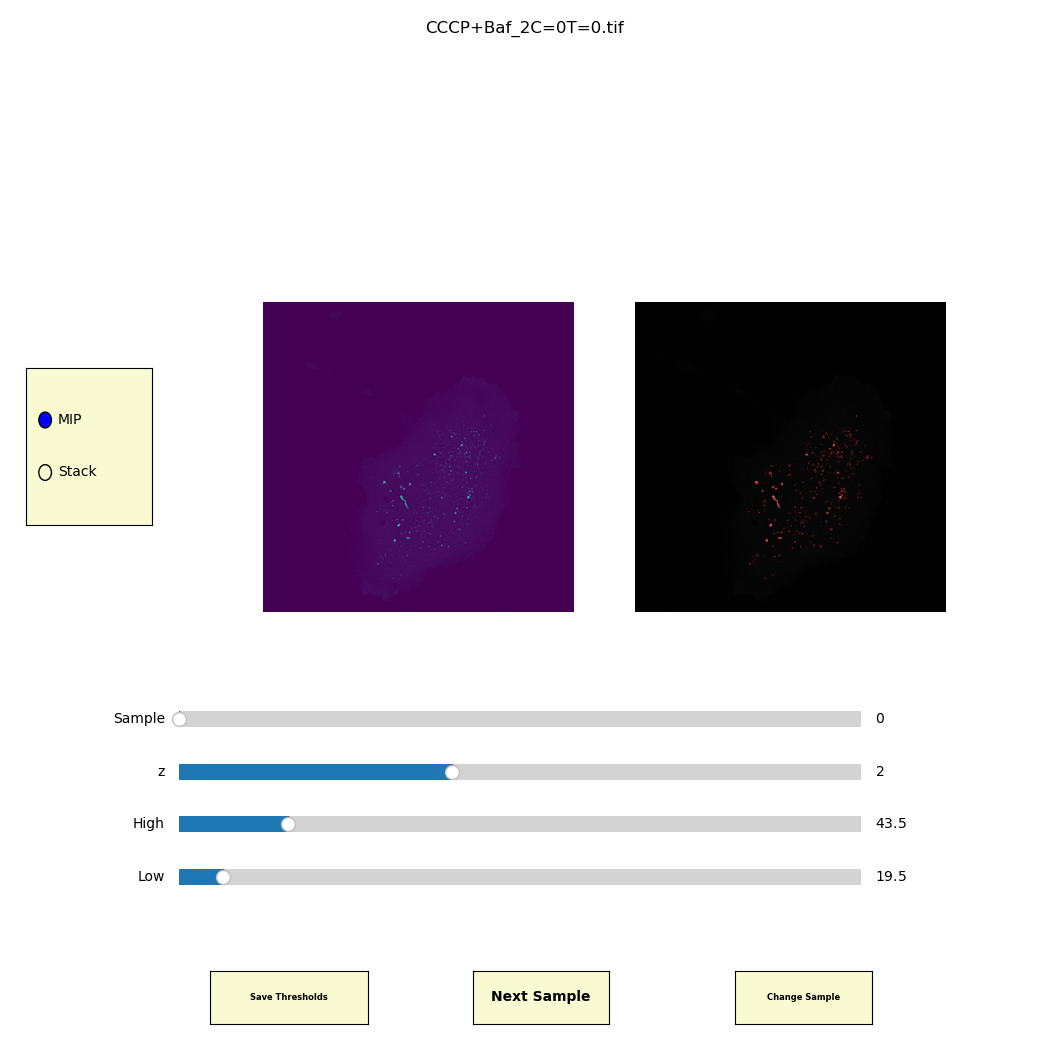

In [11]:
sample0 = 0
initial_sample = read_sample(list_of_files[sample0][0])
initial_name = list_of_files[sample0][1]
z0 = int((initial_sample.shape[0]/2)-1)
low_thresh = np.max(initial_sample)
high_thresh = np.max(initial_sample)
retreive_params()
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10.5, 10.5))
plt.subplots_adjust(left=0.25, bottom=0.25)
fig1.suptitle(initial_name)

axcolor = 'lightgoldenrodyellow'
axLow = plt.axes([0.17, 0.15, 0.65, 0.03], facecolor=axcolor)
axHigh = plt.axes([0.17, 0.2, 0.65, 0.03], facecolor=axcolor)
axZ = plt.axes([0.17, 0.25, 0.65, 0.03], facecolor=axcolor)
axSample = plt.axes([0.17, 0.3, 0.65, 0.03], facecolor=axcolor)
mipax = plt.axes([0.025, 0.5, 0.12, 0.15], facecolor=axcolor)
axSave = plt.axes([0.2, 0.025, 0.15, 0.05])
button_ax1 = plt.axes([0.7, 0.025, 0.13, 0.05])
nextSample_ax = plt.axes([0.45, 0.025, 0.13, 0.05])

if initial_name in threshold_params:
    low_init = threshold_params[initial_name]['low']
    high_init = threshold_params[initial_name]['high']
    print(low_init, high_init)
else:
    low_init = np.min(initial_sample)
    high_init = high_thresh/2

sample_slide = pylab.Slider(axSample, 'Sample', 0, len(list_of_files)-1, valinit=0, valstep = 1)
low_slide = pylab.Slider(axLow, 'Low', np.min(initial_sample), np.max(initial_sample), valinit=low_init)
high_slide = pylab.Slider(axHigh, 'High', np.min(initial_sample), np.max(initial_sample), valinit=high_init)
z_slide = pylab.Slider(axZ, 'z', 0, initial_sample.shape[0] - 1, valinit=int((initial_sample.shape[0]/2)-1), valstep = 1)
saveButton = pylab.Button(axSave, 'Save Thresholds', color=axcolor, hovercolor='0.975')
saveButton.label.set_fontsize(6)
saveButton.label.set_fontweight('bold')
sampleButton = pylab.Button(button_ax1, 'Change Sample', color=axcolor, hovercolor='0.975')
sampleButton.label.set_fontsize(6)
sampleButton.label.set_fontweight('bold')
nextSample = pylab.Button(nextSample_ax, 'Next Sample', color=axcolor, hovercolor='0.975')
nextSample.label.set_fontweight('bold')
mip_switch = RadioButtons(mipax, ('MIP', 'Stack'), active=0)
masked_image, mask_overlay = mask_image(initial_sample, low_slide.val, high_slide.val)
ax1.imshow(display_image(initial_sample))
ax2.imshow(display_image(mask_overlay/255))
ax1.axis('off')
ax2.axis('off')

low_slide.on_changed(updateThresh)
high_slide.on_changed(updateThresh)
z_slide.on_changed(updateZ)
sampleButton.on_clicked(updateSample)
mip_switch.on_clicked(updateMIP)
saveButton.on_clicked(save_params)
nextSample.on_clicked(nextSample1)

plt.show()

In [12]:
print(threshold_params.keys())
sample_list = [(list_of_files[i][1], i) for i in range(len(list_of_files))]
print(processing_time_string)

dict_keys(['CCCP+Baf_2C=0T=0.tif', 'CCCP+Baf_2C=1T=0.tif', 'CCCP_1C=0T=0.tif', 'CCCP_1C=1T=0.tif', 'CCCP_2C=0T=0.tif', 'CCCP_2C=1T=0.tif', 'N2CCCP+Baf_1C=1T=0.tif', 'N2CCCP+Baf_3C=0T=0.tif', 'N2CCCP+Baf_4C=1T=0.tif', 'N2Con_3C=0T=0.tif', 'N2Con_3C=1T=0.tif', 'N2Rapa+CCCP+Baf_1C=1T=6.tif', 'N3CCCP+Baf_1C=1T=0.tif', 'N3CCCP+Baf_2C=0T=0.tif', 'N3CCCP_2C=0T=0.tif', 'N3CCCP_4C=1T=1.tif', 'N3CCCP_4C=1T=10.tif', 'N3Con_1C=0T=1.tif', 'N3Con_1C=0T=2.tif', 'N3Con_1C=1T=1.tif', 'N3Con_1C=1T=8.tif', 'N4CCCP_1C=0T=0.tif', 'N4CCCP_1C=1T=2.tif', 'N4CCCP_2C=0T=3.tif', 'N4CCCP_2C=1T=10.tif'])



Sample Options: ['0', '1', '2']
2
{(0, 0): [0, 'Inverted', '0'], (0, 1): [1, 'Inverted', '1'], (0, 2): [2, 'Inverted', '2'], (3, 0): [3, 'Logistic', '0'], (3, 1): [4, 'Logistic', '1'], (3, 2): [5, 'Logistic', '2']}
['Inverted', '0']


0

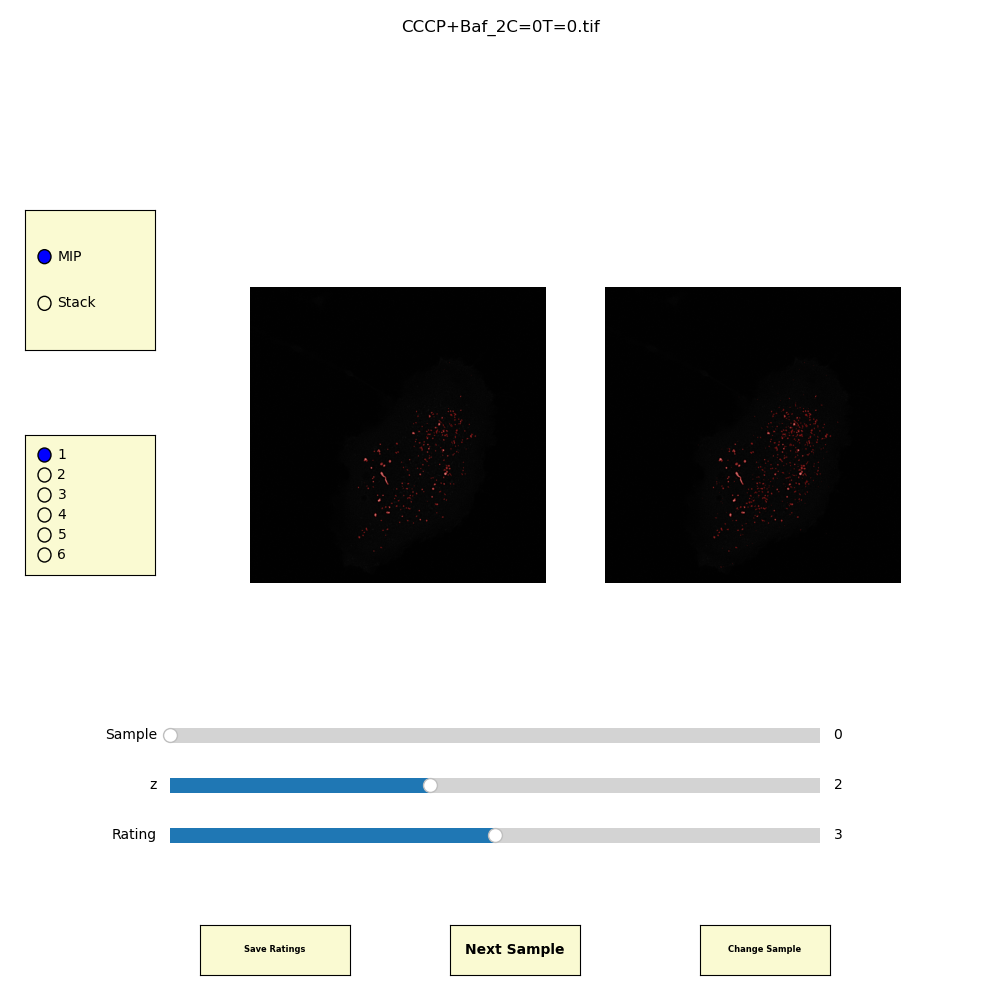

In [13]:
mip_view2 = True
auto_path = "C:\\RESEARCH\\Mitophagy_data\\Time_split\\Thresholded\\"
thresholded_samples, thresholded_names = extract_thresholded(auto_path)
sample_details = sample_to_path(thresholded_names)
sample1 = 0
low2 = sample_details[sample1][2]
high2 = sample_details[sample1][3]
initial_name2 = sample_details[sample1][1]
sample_name2 = initial_name2.split(".")[0]
sample_options = list(thresholded_samples[sample_name2]["Inverted"])
print("Sample Options:", sample_options)
initial_sample2 = read_sample(sample_details[sample1][0])

z1 = int((initial_sample2.shape[0]/2)-1)
print(z1)
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 10))
plt.subplots_adjust(left=0.25, bottom=0.25)
fig2.suptitle(initial_name2)

axcolor = 'lightgoldenrodyellow'
axZ2 = plt.axes([0.17, 0.2, 0.65, 0.03], facecolor=axcolor)
axSample2 = plt.axes([0.17, 0.25, 0.65, 0.03], facecolor=axcolor)
mipax2 = plt.axes([0.025, 0.65, 0.13, 0.14], facecolor=axcolor)
# typeAx = plt.axes([0.025, 0.5, 0.13, 0.14], facecolor=axcolor)
# optionAx = plt.axes([0.025, 0.35, 0.13, 0.14], facecolor=axcolor)
axSave2 = plt.axes([0.2, 0.025, 0.15, 0.05])
button_ax2 = plt.axes([0.7, 0.025, 0.13, 0.05])
next_sample_axes = plt.axes([0.45, 0.025, 0.13, 0.05])
axRating = plt.axes([0.17, 0.15, 0.65, 0.03], facecolor=axcolor)
typeOptAx = plt.axes([0.025, 0.425, 0.13, 0.14], facecolor=axcolor)

sample_slide2 = pylab.Slider(axSample2, 'Sample', 0, len(sample_details)-1, valinit=0, valstep = 1)
z_slide2 = pylab.Slider(axZ2, 'z', 0, initial_sample2.shape[0] - 1, valinit=int((initial_sample2.shape[0]/2)-1), valstep = 1)
rating_slide = pylab.Slider(axRating, 'Rating', 1, 5, valinit=3, valstep = 1)
saveButton2 = pylab.Button(axSave2, 'Save Ratings', color=axcolor, hovercolor='0.975')
saveButton2.label.set_fontsize(6)
saveButton2.label.set_fontweight('bold')
sampleButton2 = pylab.Button(button_ax2, 'Change Sample', color=axcolor, hovercolor='0.975')
sampleButton2.label.set_fontsize(6)
sampleButton2.label.set_fontweight('bold')
next_sample_button = pylab.Button(next_sample_axes, 'Next Sample', color=axcolor, hovercolor='0.975')
next_sample_button.label.set_fontweight('bold')
mip_switch2 = RadioButtons(mipax2, ('MIP', 'Stack'), active=0)
'''type_switch = RadioButtons(typeAx, ('Inverted', 'Logistic'), active=0)
option_switch = RadioButtons(optionAx, sample_options, active=0)'''
type_option_switch = RadioButtons(typeOptAx, ('1', '2', '3', '4', '5', '6'), active=0)
thresh_type_selected = 0
thresh_option_selected = 0
# thresholded_images = load_thresh_variants(auto_path, sample_name2, thresholded_samples)
thresholded_images, image_configs = combine_images(auto_path, sample_name2, thresholded_samples)
print(image_configs)
print(image_configs[(thresh_type_selected, thresh_option_selected)][1:])
ax3.imshow(display_image2(apply_thresholding()))
ax4.imshow(display_image2(thresholded_images[thresh_type_selected + thresh_option_selected]))
ax3.axis('off')
ax4.axis('off')

z_slide2.on_changed(updateZ2)
mip_switch2.on_clicked(updateMIP2)
'''type_switch.on_clicked(updateThreshType)
option_switch.on_clicked(updateThreshOption)'''
type_option_switch.on_clicked(updateThreshTypeOption)
sampleButton2.on_clicked(updateSample2)
saveButton2.on_clicked(save_ratings)
rating_slide.on_changed(record_rating)
next_sample_button.on_clicked(nextSample2)

In [16]:
print(sample_ratings)

{'CCCP+Baf_2C=0T=0.tif': {'Inverted0': 3}}
